In [1]:
from importlib import reload
import sys
sys.path.append("..")

from matplotlib import pylab as plt

import create_data
import models
reload(create_data)
reload(models)

<module 'models' from '/Users/rzeller/Documents/code/sandbox/notebooks/../models.py'>

# Test CNN on its own

We'll train the CNN to predict the mnist labels.

In [6]:
df = create_data.create_synthetic_data()

x_train, y_train, x_test, y_test = models.preprocess_images(df)
cnn = models.create_cnn(input_shape=x_train[0].shape + (1,), summarize=True, regress=True)

cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 10
history = cnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs,
          batch_size=32, verbose=True)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 32)       128 

(0.975, 1.0)

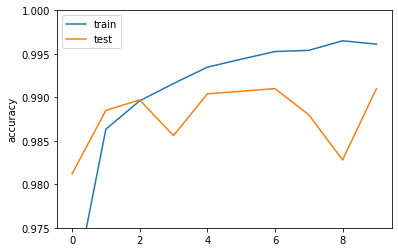

In [7]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.ylim([0.975, 1])

# Test MLP on its own

We'll train an MLP to predict the shipping fee given the pickup and dropoff locations and the mnist label given. By using the mnist label directly, this should mimic a scenario where the combined model does a good job of learning the useful information from the images.

In [14]:
continuous = ['pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y']
categorical = ['mnist_label']
layer_sizes = [32, 32]
epochs = 10
    
x_train, y_train, x_test, y_test = models.preprocess_features(df, continuous=continuous, categorical=categorical)
mlp = models.create_mlp(num_features=x_train.shape[1], layer_sizes=layer_sizes, regress=True, summarize=True)

mlp.compile(optimizer="adam", loss="mse", metrics=["mse"])

history = mlp.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs,
          batch_size=32, verbose=True)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_15 (Dense)            (None, 32)                480       
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,569
Trainable params: 1,569
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1875/1875 [==============================] - 2s 777us/step - loss: 5.2635 - mse: 5.2635 - val_loss: 0.3403 - val_mse: 0.3403
Epoch 2/10
1875/1875 [==========================

(0.0, 0.3)

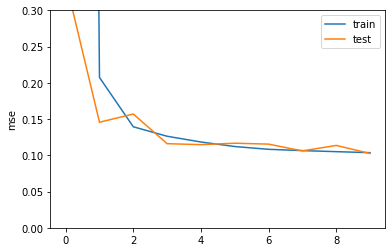

In [19]:
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend(loc='best')
plt.ylabel('mse')
plt.ylim([0, .3])

# Test the combined model

In [30]:
import numpy as np
from tensorflow.keras.layers import concatenate, Dense
from tensorflow.keras.models import Model

continuous = ['pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y']
categorical = None
mlp_layer_sizes = [32, 32]
combined_layer_sizes = [32, 32, 32]


images_train, _, images_test, _ = models.preprocess_images(df)
features_train, y_train, features_test, y_test = models.preprocess_features(df, continuous=continuous, categorical=None)
x_train = [images_train, features_train]
x_test = [images_test, features_test]


cnn = models.create_cnn(input_shape=images_train[0].shape + (1,))
mlp = models.create_mlp(num_features=features_train.shape[1], layer_sizes=mlp_layer_sizes)

def create_combined_model(mlp, cnn, layer_sizes=[32, 32]):
    combined_output = concatenate([cnn.output, mlp.output])

    for i, layer_size in enumerate(combined_layer_sizes):
        if i == 0:
            x = combined_output
        x = Dense(4, activation="relu")(x)


    x = Dense(1, activation="linear")(x)
    
    model = Model(inputs=[cnn.input, mlp.input], outputs=x)
    
    return model

model = create_combined_model(mlp, cnn, layer_sizes=combined_layer_sizes)


epochs = 10

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=epochs,
          batch_size=32, verbose=True)



Epoch 1/10
1875/1875 [==============================] - 38s 20ms/step - loss: 6.5538 - mse: 6.5538 - val_loss: 4.9818 - val_mse: 4.9818
Epoch 2/10
1875/1875 [==============================] - 39s 21ms/step - loss: 3.1002 - mse: 3.1002 - val_loss: 1.6767 - val_mse: 1.6767
Epoch 3/10
1875/1875 [==============================] - 39s 21ms/step - loss: 1.2557 - mse: 1.2557 - val_loss: 1.0110 - val_mse: 1.0110
Epoch 4/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.7141 - mse: 0.7141 - val_loss: 0.7647 - val_mse: 0.7647
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.5761 - mse: 0.5761 - val_loss: 0.8456 - val_mse: 0.8456
Epoch 6/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.5063 - mse: 0.5063 - val_loss: 0.6173 - val_mse: 0.6173
Epoch 7/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.4550 - mse: 0.4550 - val_loss: 0.6615 - val_mse: 0.6615
Epoch 8/10
1875/1875 [==========================

In [61]:
import numpy as np
from tensorflow.keras.layers import concatenate, Dense
from tensorflow.keras.models import Model
import models
reload(models)

continuous = ['pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y']
categorical = None
mlp_layer_sizes = [32, 32]
combined_layer_sizes = [32, 32, 32]


x_train, y_train, x_test, y_test = models.preprocess(df, continuous=continuous, categorical=categorical)
# images_train, features_train = x_train
# images_test, features_test = x_test

model = models.create_combined_model(image_shape=x_train[0][0].shape + (1,), 
                                     num_features=x_train[1].shape[1], 
                                     mlp_layer_sizes=mlp_layer_sizes, 
                                     combined_layer_sizes=combined_layer_sizes)


epochs = 10

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=epochs,
          batch_size=32, verbose=True)



Epoch 1/10
1875/1875 [==============================] - 24s 13ms/step - loss: 3.0434 - mse: 3.0434 - val_loss: 0.8752 - val_mse: 0.8752
Epoch 2/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.5661 - mse: 0.5661 - val_loss: 0.6792 - val_mse: 0.6792
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.4313 - mse: 0.4313 - val_loss: 0.8667 - val_mse: 0.8667
Epoch 4/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3628 - mse: 0.3628 - val_loss: 0.4306 - val_mse: 0.4306
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2987 - mse: 0.2987 - val_loss: 0.4679 - val_mse: 0.4679
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.2600 - mse: 0.2600 - val_loss: 0.3971 - val_mse: 0.3971
Epoch 7/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.2508 - mse: 0.2508 - val_loss: 0.3915 - val_mse: 0.3915
Epoch 8/10
1875/1875 [==========================

(0.0, 2.0)

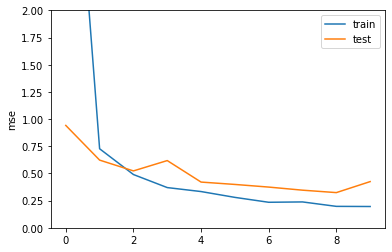

In [44]:
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend(loc='best')
plt.ylabel('mse')
plt.ylim([0,2])

With some hyperparameter tuning, we can get the network to achieve an MSE that is on the same order as the MLP that was given the mnist labels directly. Next, let's see if we can use multi-task learning where the weights are given for some of the data to improve the performance.

# Multi-task learning

In [78]:
import numpy as np
from tensorflow.keras.layers import concatenate, Dense
from tensorflow.keras.models import Model
import models
reload(models)

continuous = ['pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y']
categorical = None
mlp_layer_sizes = [32, 32]
combined_layer_sizes = [32, 32, 32]


processed_data = models.preprocess_multitask(df, continuous=continuous, categorical=categorical)
x_train, weights_train, fees_train, x_test, weights_test, fees_test = processed_data
    
model = models.create_multitask_model(image_shape=x_train[0][0].shape + (1,), 
                                      num_features=x_train[1].shape[1],
                                      mlp_layer_sizes=mlp_layer_sizes,
                                      combined_layer_sizes=combined_layer_sizes,
                                      weight_input='cnn'
                                     )


epochs = 10

model.compile(optimizer='adam', loss='mse', metrics=['mse'], loss_weights={'weight': 1e-1, 'shipping_fee': 1.})

history = model.fit(x=x_train, 
                    y={'weight': weights_train, 'shipping_fee': fees_train},
                    validation_data=(x_test, {'weight': weights_test, 'shipping_fee': fees_test}),
                    epochs=epochs,
                    batch_size=32,
                    verbose=True
                   )


Epoch 1/10
1875/1875 [==============================] - 22s 11ms/step - loss: 2.9908 - weight_loss: 0.2287 - shipping_fee_loss: 2.9679 - weight_mse: 0.2287 - shipping_fee_mse: 2.9679 - val_loss: 0.7988 - val_weight_loss: 0.1190 - val_shipping_fee_loss: 0.7869 - val_weight_mse: 0.1190 - val_shipping_fee_mse: 0.7869
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.6207 - weight_loss: 0.1028 - shipping_fee_loss: 0.6104 - weight_mse: 0.1028 - shipping_fee_mse: 0.6104 - val_loss: 0.4816 - val_weight_loss: 0.0926 - val_shipping_fee_loss: 0.4723 - val_weight_mse: 0.0926 - val_shipping_fee_mse: 0.4723
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4205 - weight_loss: 0.0907 - shipping_fee_loss: 0.4114 - weight_mse: 0.0907 - shipping_fee_mse: 0.4114 - val_loss: 0.5880 - val_weight_loss: 0.0901 - val_shipping_fee_loss: 0.5790 - val_weight_mse: 0.0901 - val_shipping_fee_mse: 0.5790
Epoch 4/10
1875/1875 [==============================

(0.0, 2.0)

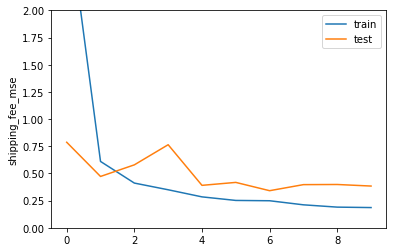

In [79]:
metric = 'shipping_fee'
plt.plot(history.history[metric + '_mse'], label='train')
plt.plot(history.history['val_' + metric + '_mse'], label='test')
plt.legend(loc='best')
plt.ylabel(metric + '_mse')
plt.ylim([0,2])